In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
%matplotlib inline
import matplotlib.pyplot as plt

In [74]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)

In [75]:
from itertools import tee, chain, islice
import numpy as np
import random
from time import time

In [76]:
from eden.converter.graph.gspan import gspan_to_eden
def get_graphs(dataset_fname, size=200):
    return  islice(gspan_to_eden(dataset_fname),size)

In [77]:
from graphlearn.graphlearn import GraphLearnSampler
from eden.util import fit,estimate
from eden.graph import Vectorizer


def fit_and_evaluate(pos_original, neg_original,
                     pos_augmented, neg_augmented,
                     pos_test, neg_test):
    # create graph sets...orig augmented and sampled
    pos_orig,pos_orig_ = tee(pos_original)
    neg_orig,neg_orig_ = tee(neg_original)
    
    pos_augmented , pos_sampled = tee(pos_augmented)
    neg_augmented , neg_sampled = tee(neg_augmented)
    
    pos_augmented = chain(pos_augmented,pos_orig_)
    neg_augmented = chain(neg_augmented,neg_orig_)

    predictive_performances = []
    for desc,pos_train,neg_train in [('original',pos_orig, neg_orig),( 'original+sample',pos_augmented, neg_augmented),('sample',pos_sampled,neg_sampled)]:
        pos_train,pos_train_ = tee(pos_train)
        neg_train,neg_train_ = tee(neg_train)
        pos_size=sum(1 for x in pos_train_)
        neg_size=sum(1 for x in neg_train_)
        start=time()
        print "-"*80
        print 'working on %s'%(desc)
        print 'training set sizes: #pos: %d #neg: %d'%(pos_size, neg_size)
        pos_test,pos_test_ = tee(pos_test)
        neg_test,neg_test_ = tee(neg_test)
        local_estimator = fit(pos_train, neg_train, Vectorizer(2), n_jobs=1, n_iter_search=1)
        apr, roc = estimate(pos_test_, neg_test_, local_estimator, Vectorizer(2))
        predictive_performances.append(roc)
        print 'elapsed: %.1f sec'%(time()-start)
    return predictive_performances


def sample(graphs):
    graphs, graphs_ = tee(graphs)
    sampler=GraphLearnSampler(radius_list=[0,1],
                              thickness_list=[2],
                              min_cip_count=2, min_interface_count=2)
    sampler.fit(graphs, n_jobs=1)
    graphs = sampler.sample(graphs_,
                            same_radius=False,
                            same_core_size=False,
                            n_samples=3,
                            n_steps=6,
                            n_jobs=1,
                            accept_annealing_factor=1.2,
                            probabilistic_core_choice=True,
                            generator_mode=True)
    return graphs

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs
repetition: 0/10
training percentage:0.2
--------------------------------------------------------------------------------
working on original
training set sizes: #pos: 24 #neg: 24
Test set
Instances: 160 ; Features: 1048577 with an avg of 81 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.56      0.66      0.61        80
          1       0.59      0.49      0.53        80

avg / total       0.58      0.57      0.57       160

APR: 0.661
ROC: 0.674
elapsed: 0.9 sec
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 35 #neg: 44
Test set
Instances: 160 ; Features: 1048577 with an avg of 81 features per instance
--------------------------------------------------------------------------------
Test Est

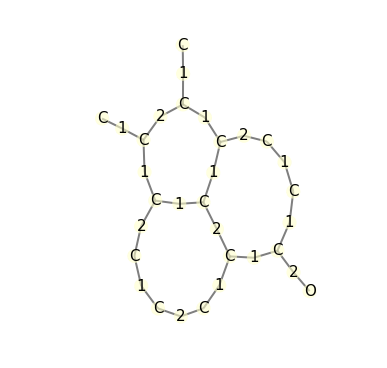

grammar


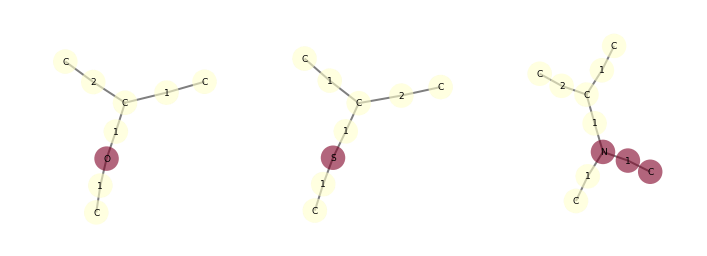

candidates


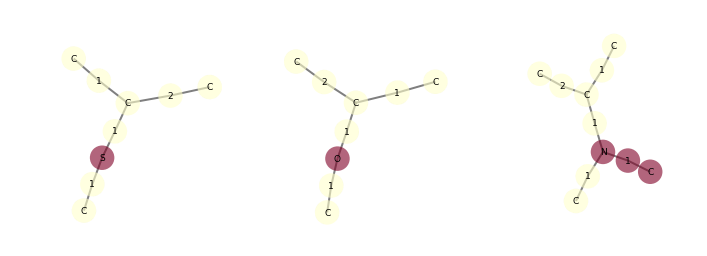

--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 127 #neg: 132
Test set
Instances: 160 ; Features: 1048577 with an avg of 81 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.76      0.72      0.74        80
          1       0.74      0.78      0.76        80

avg / total       0.75      0.75      0.75       160

APR: 0.855
ROC: 0.825
elapsed: 2.0 sec
--------------------------------------------------------------------------------
working on sample
training set sizes: #pos: 55 #neg: 60
Test set
Instances: 160 ; Features: 1048577 with an avg of 81 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.78      0.59      0.67       

In [78]:
%time

# initializing 
graphs_pos = get_graphs('bursi.pos.gspan')
graphs_neg = get_graphs('bursi.neg.gspan')

# train/test split
train_test_split = 0.6
from eden.util import random_bipartition_iter
pos_train_global,pos_test_global = random_bipartition_iter(graphs_pos,train_test_split)
neg_train_global,neg_test_global = random_bipartition_iter(graphs_neg,train_test_split)

percentages = [.2,.3,.4,.5,.6]
n_repetitions = 10

original_repetitions = []
original_sample_repetitions = []
sample_repetitions = []

for percentage in percentages:
    originals = []
    originals_samples = []
    samples = []
    for repetition in range(n_repetitions):
        pos_train_global,pos_train_global_ = tee(pos_train_global)
        neg_train_global,neg_train_global_ = tee(neg_train_global)
        pos_test_global,pos_test_global_ = tee(pos_test_global)
        neg_test_global,neg_test_global_ = tee(neg_test_global)

        # use shuffled list to create test and sample set
        pos,pos_reminder = random_bipartition_iter(pos_train_global_,percentage)
        pos,pos_ = tee(pos)
        neg,neg_reminder = random_bipartition_iter(neg_train_global_,percentage)
        neg,neg_ = tee(neg)

        #sample independently from the 2 classes
        sampled_pos = sample(pos)
        sampled_neg = sample(neg)

        #evaluate the predictive performance on held out test set
        start=time()
        print "="*80
        print 'repetition: %d/%d'%(repetition, n_repetitions)
        print "training percentage:"+str(percentage)
        perf_orig, perf_orig_samp, perf_samp = fit_and_evaluate(pos_,neg_,
                                                                sampled_pos,sampled_neg,
                                                                pos_test_global_,neg_test_global_)
        originals.append(perf_orig)
        originals_samples.append(perf_orig_samp)
        samples.append(perf_samp)
    
    original_repetitions.append(originals)
    original_sample_repetitions.append(originals_samples)
    sample_repetitions.append(samples)
    print 'Time elapsed for perc: %.2f : %.1f sec'%(percentage,(time()-start))


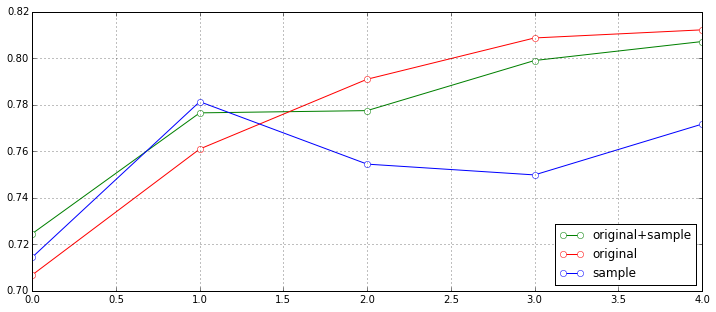

In [79]:
os = np.mean(original_sample_repetitions, axis=1)
o = np.mean(original_repetitions, axis=1)
s = np.mean(sample_repetitions, axis=1)
plt.figure(figsize=(12,5))
plt.grid()
plt.plot(os, color='g', marker='o', markersize=6, markeredgecolor='g', markerfacecolor='w', label='original+sample')
plt.plot(o, color='r', marker='o', markersize=6, markeredgecolor='r', markerfacecolor='w', label='original')
plt.plot(s, color='b', marker='o', markersize=6, markeredgecolor='b', markerfacecolor='w', label='sample')
plt.legend(loc='lower right')
plt.savefig('plot_predictive_performance_of_samples.pdf')

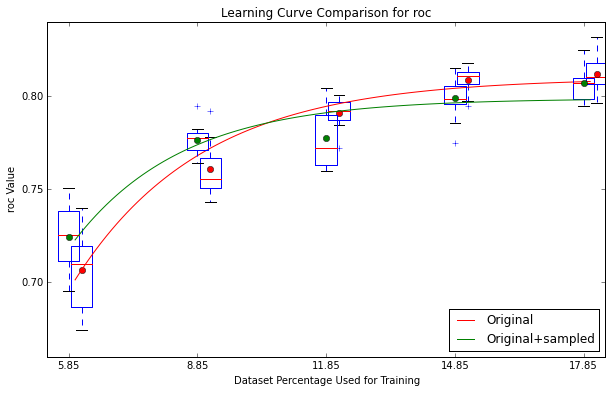

In [80]:
from graphlearn.utils.draw import draw_learning_curve
draw_learning_curve(data_first=original_repetitions,
                    data_second=original_sample_repetitions,
                    x_axis=percentages,
                    measure='roc',
                    delta=0.005,scaling=30)